## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card
* Bank account services
* Theft/Dispute reporting
* Mortgages/loans
* Others 


1. With the help of topic modelling, you will be able to map each ticket onto its respective department/category. 
2. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department. At least any 3 models from logistic regression, naive Bayes, decision tree and random forest need to be tried and need to select the model that performs the best according to the evaluation metrics.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()

COLAB = False

In [2]:
import missingno as msno

SAMPLE_SIZE = 1000 #1000 # 100
SAMPLE_INDEX =  316 # 36

def percent(val, total):
    return round(100 * val/total, 2)
    
def getDFInfo(df_):
    print(f"ROWS: {df_.shape[0]}, COLUMNS: {df_.shape[1]}"); print(f"COLUMNS: {df_.columns.tolist()}")
    print(f"\nMISSING DATA: {percent(df_.isnull().sum().sum(), (df_.shape[0]*df_.shape[1]))}%")

def roundOff(value):
    #print(type(value))
    return (value/1000000).round(1)


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
if COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    f = open("/content/gdrive/My Drive/Colab Notebooks/complaints.json", "r")# Write the path to your data file and load it 
else:
    f = open("complaints.json", "r")# Write the path to your data file and load it 

print(f.name, type(f))
# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

complaints.json <class '_io.TextIOWrapper'>


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
df[['_source.issue', '_source.sub_issue', '_source.complaint_what_happened']].head()

,_source.issue,_source.sub_issue,_source.complaint_what_happened
0,Attempts to collect debt not owed,Debt is not yours,
1,Written notification about debt,Didn't receive enough information to verify debt,Good morning my name is XXXX XXXX and I apprec...
2,"Other features, terms, or problems",Problem with rewards from credit card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Trouble during payment process,None,
4,Fees or interest,Charged too much interest,


In [8]:
df['_source.issue'].head()

0     Attempts to collect debt not owed
1       Written notification about debt
2    Other features, terms, or problems
3        Trouble during payment process
4                      Fees or interest
Name: _source.issue, dtype: object

In [9]:
df[ '_source.sub_issue'].head()

0                                   Debt is not yours
1    Didn't receive enough information to verify debt
2               Problem with rewards from credit card
3                                                None
4                           Charged too much interest
Name: _source.sub_issue, dtype: object

In [10]:
df['_source.complaint_what_happened'].head()

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                     
4                                                     
Name: _source.complaint_what_happened, dtype: object

In [11]:
#Assign new column names
df.rename(columns = {'_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


BEFORE: 57241 0 21072
AFTER: 0 57241 78313


<AxesSubplot:>

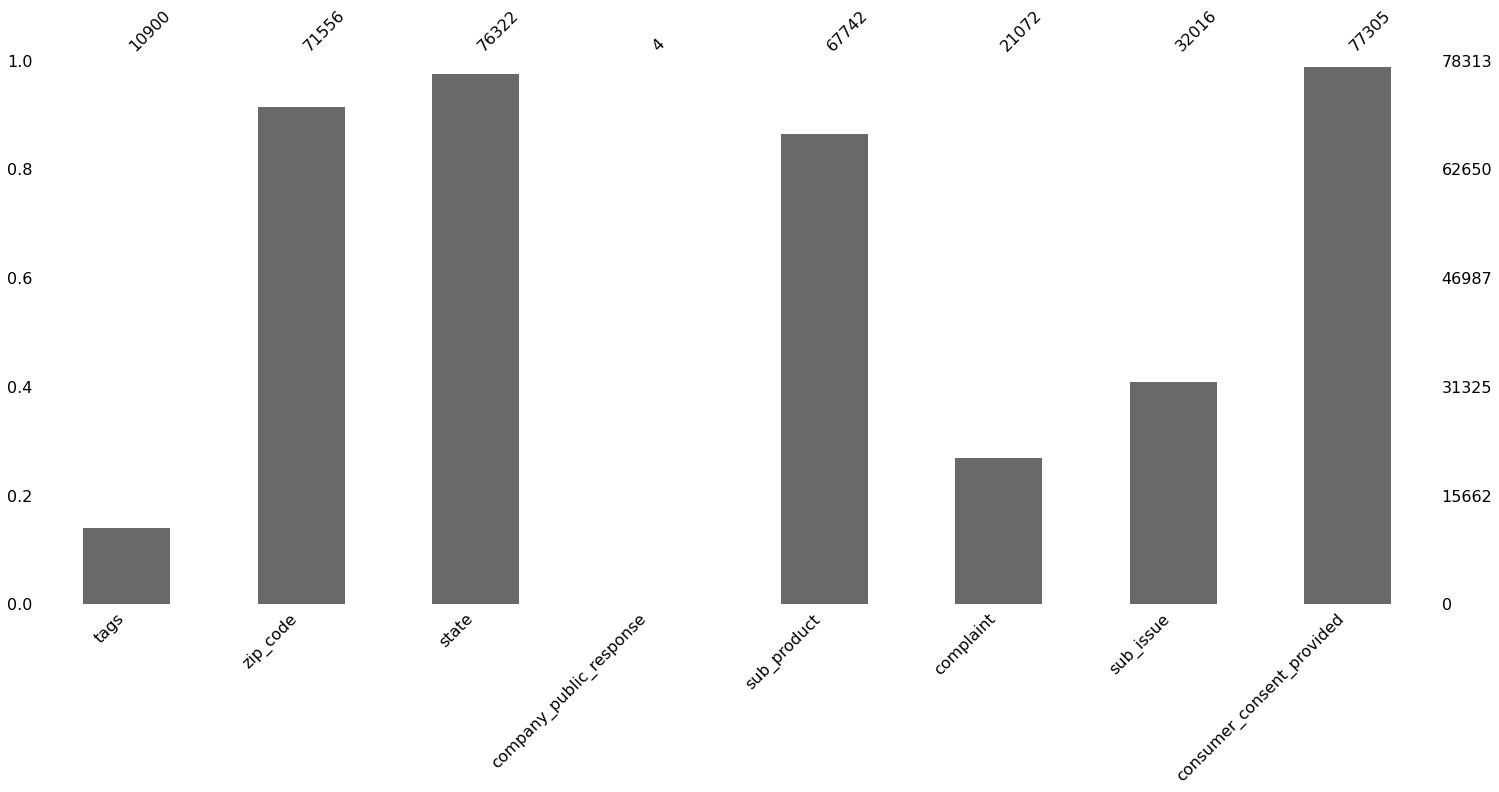

In [12]:
#Assign nan in place of blanks in the complaints column
print(f"BEFORE: {df[df['complaint']==''].shape[0]} {df[df['complaint'].isnull()]['complaint'].shape[0]} {df[~(df['complaint']=='')].shape[0]}")
df['complaint'].replace('', np.NaN, inplace=True)
print(f"AFTER: {df[df['complaint']==''].shape[0]} {df[df['complaint'].isnull()]['complaint'].shape[0]} {df[~(df['complaint']=='')].shape[0]}")
msno.bar(df[df.columns[df.isnull().any()]])

In [13]:
#Remove all rows where complaints column is nan
print(f"BEFORE: {df.shape[0]}")
df = df[~df['complaint'].isnull()]
df.reset_index(inplace=True)
print(f"AFTER: {df.shape[0]}")

BEFORE: 78313
AFTER: 21072


## TODO: SELECT ONLY A SMALL SAMPLE
To undo later

In [14]:
if COLAB == False: df = df.head(SAMPLE_SIZE)
print(df.shape[0])

1000


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


#### Make the text lowercase

In [15]:
# Make the text lowercase
print(f"BEFORE: {df['complaint'][SAMPLE_INDEX][:40]}")
df['complaint'] = df['complaint'].str.lower()
print(f"AFTER: {df['complaint'][SAMPLE_INDEX][:40]}")

BEFORE: My father in-law did my taxes and had th
AFTER: my father in-law did my taxes and had th


#### Remove text in square brackets, punctuation, words containing numbers

In [16]:
# REG EXPRESSIONS
REG_TEXT_IN_SQ_BRKTS = r'\[.+?\]'
REG_PUNCT = r'[^\w\s]'
REG_WORD_WITH_NUM = r'[\w]*\d[\w]*'

In [17]:
# Test Reg expressions on a sample text
TEXT = 'Sreedevi he[ll]o!! see23y[5ou] Goodday'
re.findall(REG_TEXT_IN_SQ_BRKTS, TEXT)

['[ll]', '[5ou]']

In [18]:
# Test the reg expression on the text in the dataframe
s2 = df.loc[SAMPLE_INDEX, 'complaint']; print("Before Substitution:", len(s2), s2[0:20])
s2 = re.sub(REG_TEXT_IN_SQ_BRKTS, '', s2); print("REG_TEXT_IN_SQ_BRKTS", len(s2), s2[0:20])
s2 = re.sub(REG_PUNCT, '', s2); print("REG_PUNCT", len(s2), s2[0:20])
s2 = re.sub(REG_WORD_WITH_NUM, '', s2); print("REG_WORD_WITH_NUM", len(s2), s2[0:20]) #s2

Before Substitution: 545 my father in-law did
REG_TEXT_IN_SQ_BRKTS 545 my father in-law did
REG_PUNCT 524 my father inlaw did 
REG_WORD_WITH_NUM 512 my father inlaw did 


In [19]:
DICT_REG = {'REG_TEXT_IN_SQ_BRKTS':REG_TEXT_IN_SQ_BRKTS, 'REG_PUNCT':REG_PUNCT, 'REG_WORD_WITH_NUM':REG_WORD_WITH_NUM}
for desc, reg in DICT_REG.items():
    df_reg = df[df['complaint'].str.contains(reg, regex=True)]['complaint']
    if df_reg.shape[0] == 0: continue
    
    print(desc, df_reg.shape[0])
    sample = df_reg.head().tolist()[0]

    print("BEFORE substitution")
    idx = df_reg.index[0]
    sample = df.loc[idx, 'complaint']
    print(idx, sample[:20])

    hits = re.findall(reg, sample)
    print(len(hits))
    [print(hit) for hit in hits]

    # Substitute
    df['complaint'] = df['complaint'].replace(reg, '', regex=True)

    print();print("AFTER substitution")
    df_reg = df[df['complaint'].str.contains(reg, regex=True)]['complaint']
    samples = df_reg.head().tolist()
    if len(samples) > 0:
        sample = samples[0]
        idx = df_reg.index[0]
        sample = df.loc[idx, 'complaint']
        print(idx, sample[:20])

        hits = re.findall(reg, sample)
        print(len(hits))
        [print(hit) for hit in hits]
    else:
        print("No hits")

    print("\n")

REG_TEXT_IN_SQ_BRKTS 9
BEFORE substitution
131 re : complaint again
12
[ t ]
[ fico scores, xxxx, xxxx and xxxx, respectively ]
[ 1427 -3272.9 ]
[ 1708 1725 ]
[ cc and her supervisor, mr. xxxx xxxx eventually, executive director, mr. xxxx xxxx ]
[ 8000 - 22980 ]
[ 11000 - 15986 ]
[ 1290012996 ]
[ 12925-12928 ]
[ 1 ]
[ which we did ]
[ 2 trusted agents of jp morgan chase ]

AFTER substitution
No hits


REG_PUNCT 992
BEFORE substitution
0 good morning my name
7
.
.
.
.
.
#
.

AFTER substitution
No hits


REG_WORD_WITH_NUM 809
BEFORE substitution
0 good morning my name
1
2018

AFTER substitution
No hits




In [20]:
df[df['complaint'].str.contains(REG_TEXT_IN_SQ_BRKTS, regex=True)]['complaint'].shape[0],               \
        df[df['complaint'].str.contains(REG_PUNCT, regex=True)]['complaint'].shape[0],                  \
            df[df['complaint'].str.contains(REG_WORD_WITH_NUM, regex=True)]['complaint'].shape[0],

(0, 0, 0)

####  Lemmatize the texts

In [21]:
# Write your function to Lemmatize the texts
### import necessary libraries
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
#nltk.download('omw-1.4')

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens if not token in set(stopwords.words('english'))]
    return lemmatized

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sreedevigattu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sreedevigattu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sreedevigattu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df['complaint'].head()

0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in  and was told ...
2    chase card was reported on  however fraudulent...
3    on  while trying to book a xxxx  xxxx  ticket ...
4    my grand son give me check for  i deposit it i...
Name: complaint, dtype: object

In [23]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaint'] = df['complaint']
df_clean['complaint_lemma'] = df_clean['complaint'].progress_apply(lambda x: lemmatize(x))

100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


In [24]:
df_clean.head()

,complaint,complaint_lemma
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ..."
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr..."
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a..."
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros..."
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco..."


In [25]:
print(df['complaint'].head(1).values[0])
' '.join(lemmatize(df['complaint'].head(1).values[0]))

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help


'good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help'

#### Use POS tags to get relevant words from the texts.

In [26]:
TRACE_IN_N_LINES = 200
def printOnceInNTimes(msg, count):
    #print(msg, count, onceIn)
    if count%TRACE_IN_N_LINES == 0: print(msg)

In [27]:
df_clean.shape

(1000, 2)

In [28]:
# Write your function to extract the POS tags 

'''
Out of all the POS tags, we 
need:           ADJ, ADV, NOUN, PROPN, VERB
do not need:    ADP, PUNCT, AUX, SYM, INTJ, CCONJ, X, DET, NUM, PART, PRON, SCONJ
'''

# RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'] # 0
# RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN', 'PROPN'] # 1
RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN'] # 2
# RELEVANT_POS_TAGS = ['NOUN', 'PROPN'] # 3

# shorten the pipline loading
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

count = 0
#for review in tqdm(df_clean['complaint_lemma'].to_list()[0:1000]):
RELEVANT_WORDS = []
POS_TAGS = {}
for index, row in tqdm(df_clean.iterrows()):
    relevant_words = []
    count += 1
    review = row['complaint_lemma']
    printOnceInNTimes(f"{count}: LEMMA: {review[:20]}", count)

    review = ' '.join(review)
    doc = nlp(review)
    for tok in doc:
        POS_TAGS[tok.pos_] = 1
        if tok.pos_ in RELEVANT_POS_TAGS: relevant_words.append(tok.lemma_)

    printOnceInNTimes(f"RELEVANT_WORDS: {relevant_words[:40]}", count)
    relevant_words = " ".join(relevant_words)
    printOnceInNTimes(f"RELEVANT_WORDS: {relevant_words[:40*10]}", count)

    RELEVANT_WORDS.append(relevant_words)
    printOnceInNTimes("", count)

print(POS_TAGS.keys())
df_clean['complaint_POS_removed'] = RELEVANT_WORDS

215it [00:02, 93.61it/s] 

200: LEMMA: ['computer', 'purchased', 'amazon', 'item', 'defective', 'returned', 'day', 'via', 'xxxx', 'tracking', 'number', 'xxxx', 'item', 'initially', 'refunded', 'well', 'credit', 'card', 'charged', 'item']
RELEVANT_WORDS: ['computer', 'amazon', 'item', 'defective', 'day', 'xxxx', 'number', 'xxxx', 'item', 'initially', 'well', 'credit', 'card', 'item', 'downhill', 'dispute', 'submit', 'tracking', 'information', 'return', 'item', 'response', 'favor', 'seller', 'idea', 'even', 'dispute', 'letter', 'online', 'know', 'dispute', 'recall', 'chase', 'online', 'letter', 'case', 'promptly', 'documentation', 'refunded', 'amazon']
RELEVANT_WORDS: computer amazon item defective day xxxx number xxxx item initially well credit card item downhill dispute submit tracking information return item response favor seller idea even dispute letter online know dispute recall chase online letter case promptly documentation refunded amazon chase month somehow information letter chase charge valid xxxx charg

411it [00:03, 96.83it/s] 

400: LEMMA: ['jp', 'morgan', 'chase', 'erroneously', 'charged', 'end', 'lease', 'even', 'traded', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'pull', 'ahead', 'program', 'xxxx', 'xxxx', 'dealer', 'one']
RELEVANT_WORDS: ['erroneously', 'end', 'lease', 'even', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'ahead', 'program', 'xxxx', 'dealer', 'damage', 'opportunity', 'pre', 'inspection', 'therefore', 'transaction', 'immediately', 'xxxx', 'statement', 'bill', 'lease', 'liability', 'lease', 'dispute', 'letter', 'picture', 'lease', 'deal', 'new', 'dealer', 'total', 'deal', 'advantage', 'manufacturer', 'ahead', 'program', 'monthly', 'payment']
RELEVANT_WORDS: erroneously end lease even xxxx xxxx xxxx xxxx ahead program xxxx dealer damage opportunity pre inspection therefore transaction immediately xxxx statement bill lease liability lease dispute letter picture lease deal new dealer total deal advantage manufacturer ahead program monthly payment excess wear tear picture top xxxx xxxx clean inclusive transaction shady

619it [00:06, 101.46it/s]

600: LEMMA: ['greeting', 'trying', 'get', 'loan', 'modification', 'past', 'year', 'tried', 'work', 'lawyer', 'bank', 'bank', 'mailed', 'check', 'xxxx', 'returned', 'called', 'offered', 'xxxx', 'cash']
RELEVANT_WORDS: ['loan', 'modification', 'year', 'check', 'xxxx', 'xxxx', 'cash', 'wire', 'transfer', 'hung', 'phone', 'twice', 'payout', 'taxpayer', 'business', 'thief', 'paperwork', 'fighting', 'court', 'several', 'year', 'hard', 'money', 'xxxx', 'last', 'investment', 'demand', 'follow', 'law', 'home', 'loan', 'modification', 'accountable', 'street', 'purse', 'fine', 'business', 'usual', 'congressman', 'vote']
RELEVANT_WORDS: loan modification year check xxxx xxxx cash wire transfer hung phone twice payout taxpayer business thief paperwork fighting court several year hard money xxxx last investment demand follow law home loan modification accountable street purse fine business usual congressman vote mean rest american people home loan modification today time attention least agency right

812it [00:07, 128.44it/s]

800: LEMMA: ['xxxxxxxx', 'called', 'spoke', 'chase', 'auto', 'fiance', 'account', 'number', 'xxxx', 'explained', 'called', 'requested', 'billing', 'extension', 'one', 'month', 'granted', 'health', 'hospital', 'would']
RELEVANT_WORDS: ['spoke', 'chase', 'auto', 'number', 'xxxx', 'billing', 'extension', 'month', 'health', 'hospital', 'month', 'extension', 'extension', 'however', 'due', 'date', 'xxxx', 'month', 'xxxx', 'also', 'payment', 'original', 'due', 'date', 'back', 'xxxx', 'statement', 'hospital', 'agent', 'statement', 'medical', 'emergency', 'xxxx', 'xxxx', 'late', 'fee', 'amount', 'removed', 'spoke', 'supervisor']
RELEVANT_WORDS: spoke chase auto number xxxx billing extension month health hospital month extension extension however due date xxxx month xxxx also payment original due date back xxxx statement hospital agent statement medical emergency xxxx xxxx late fee amount removed spoke supervisor name xxxx d xxxx payment chase bank back fee back original due date xxxx month supe

1000it [00:09, 106.39it/s]

1000: LEMMA: ['long', 'story', 'short', 'currently', 'indiana', 'hardest', 'hit', 'program', 'chase', 'bank', 'put', 'illegal', 'judgement', 'investigation', 'claimed', 'defaulted', 'program', 'called', 'confirm', 'completed']
RELEVANT_WORDS: ['long', 'story', 'short', 'currently', 'indiana', 'hard', 'program', 'illegal', 'judgement', 'investigation', 'defaulted', 'program', 'confirm', 'xxxx', 'dollar', 'check', 'catch', 'patent', 'xxxx', 'catch', 'addition', 'insurance', 'policy', 'state', 'also', 'policy', 'year', 'xxxx', 'day', 'notice', 'homeless', 'also', 'mortgage', 'document', 'illegal', 'foreclosure']
RELEVANT_WORDS: long story short currently indiana hard program illegal judgement investigation defaulted program confirm xxxx dollar check catch patent xxxx catch addition insurance policy state also policy year xxxx day notice homeless also mortgage document illegal foreclosure

dict_keys(['ADJ', 'NOUN', 'PROPN', 'AUX', 'VERB', 'ADV', 'DET', 'ADP', 'X', 'SCONJ', 'INTJ', 'CCONJ',

In [29]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
'''df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]
df_clean.drop(labels='pos_tags',axis=1,inplace=True)'''

"df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]\ndf_clean.drop(labels='pos_tags',axis=1,inplace=True)"

In [30]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
print(df_clean.shape); df_clean.head()

(1000, 3)


,complaint,complaint_lemma,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name xxxx appreciate service chas...
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",xxxx card agent upgrade anniversary date agent...
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",grand son check deposit account never money gr...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

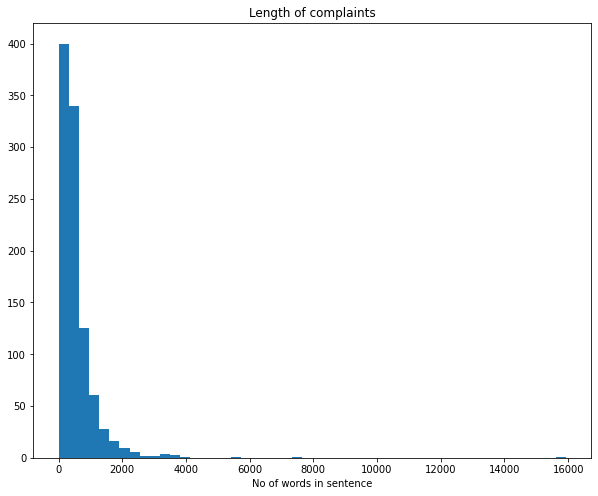

In [31]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len = [len(i) for i in df_clean['complaint_POS_removed']]
plt.figure(figsize=(10,8))
plt.hist(complaint_len,bins=50)
plt.xlabel('No of words in sentence')
plt.title('Length of complaints')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [32]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
comment_words = ""
for words in df_clean['complaint_POS_removed'].tolist():
    comment_words += words

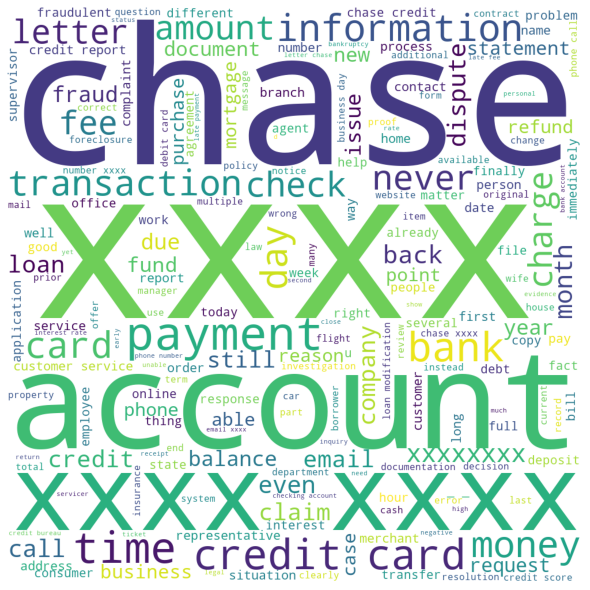

In [33]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def plotWordCloud(words):
    wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

#words = "Using a word cloud find the top 40 words by frequency among all the articles after processing the text"
plotWordCloud(comment_words)

In [34]:
df_clean['complaint_POS_removed'].head()

0    good morning name xxxx appreciate service chas...
1    xxxx card agent upgrade anniversary date agent...
2    card however fraudulent application identity c...
3    xxxx xxxx ticket offer ticket reward card info...
4    grand son check deposit account never money gr...
Name: complaint_POS_removed, dtype: object

In [35]:
# Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [36]:
df_clean['complaint_clean'].head()

0    good morning name xxxx appreciate service chas...
1    xxxx card agent upgrade anniversary date agent...
2    card however fraudulent application identity c...
3    xxxx xxxx ticket offer ticket reward card info...
4    grand son check deposit account never money gr...
Name: complaint_clean, dtype: object

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [37]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigrams(corpus,n=None):
    vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
    return words_freq[:n]

def plot_ngrams(top10):
    x = pd.DataFrame(top10,columns=['ngram','count'])
    plt.figure(figsize=(15,10))
    sns.barplot(x=x['ngram'],y=x['count'])

get_top_n_unigrams(df_clean['complaint_clean'],n=30)

[('xxxx', 5667),
 ('chase', 2468),
 ('account', 2350),
 ('credit', 1595),
 ('card', 1400),
 ('payment', 982),
 ('time', 775),
 ('day', 656),
 ('bank', 635),
 ('money', 598),
 ('charge', 560),
 ('information', 537),
 ('fee', 517),
 ('transaction', 491),
 ('letter', 472),
 ('number', 459),
 ('loan', 456),
 ('check', 421),
 ('month', 418),
 ('xxxxxxxx', 415),
 ('report', 407),
 ('service', 404),
 ('email', 390),
 ('balance', 376),
 ('customer', 371),
 ('company', 367),
 ('phone', 366),
 ('dispute', 363),
 ('year', 349),
 ('fund', 341)]

xxxx
chase
account
credit
card
payment
time
day
bank
money


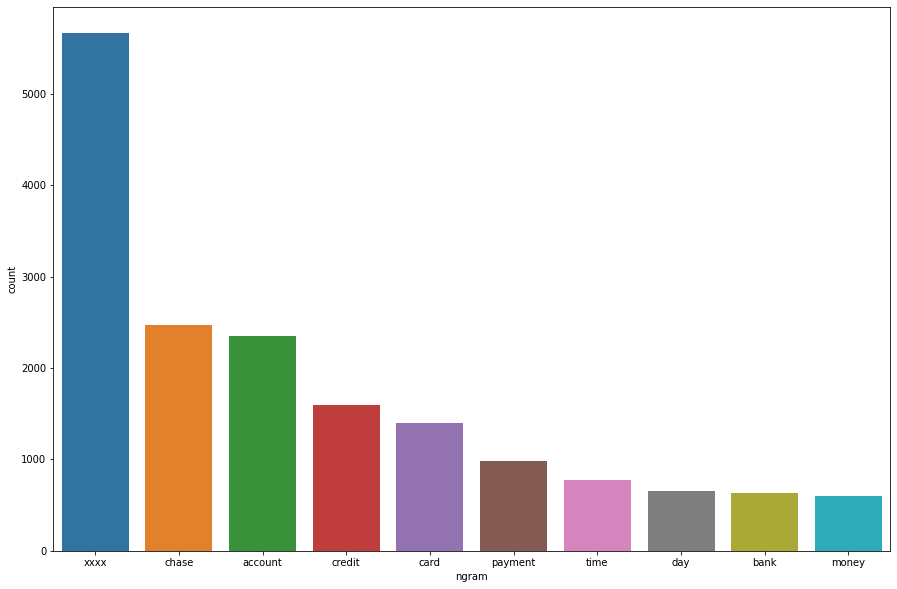

In [38]:
# Print the top 10 words in the unigram frequency
top_10_unigram = get_top_n_unigrams(df_clean['complaint_clean'], n=10)
for i in top_10_unigram:
    print(i[0])
plot_ngrams(top_10_unigram)

In [39]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_bigrams(df_clean['complaint_clean'], n=30)

[('xxxx xxxx', 1469),
 ('credit card', 618),
 ('credit report', 198),
 ('account xxxx', 168),
 ('customer service', 149),
 ('xxxx chase', 138),
 ('chase credit', 134),
 ('xxxx account', 124),
 ('payment xxxx', 119),
 ('number xxxx', 106),
 ('chase xxxx', 102),
 ('xxxx credit', 101),
 ('xxxx payment', 100),
 ('account chase', 93),
 ('debit card', 90),
 ('account account', 89),
 ('credit score', 84),
 ('business day', 82),
 ('chase account', 81),
 ('loan modification', 77),
 ('checking account', 73),
 ('card account', 71),
 ('late payment', 71),
 ('letter chase', 71),
 ('late fee', 69),
 ('bank account', 68),
 ('card xxxx', 67),
 ('credit bureau', 67),
 ('transaction xxxx', 65),
 ('email xxxx', 65)]

xxxx xxxx
credit card
credit report
account xxxx
customer service
xxxx chase
chase credit
xxxx account
payment xxxx
number xxxx


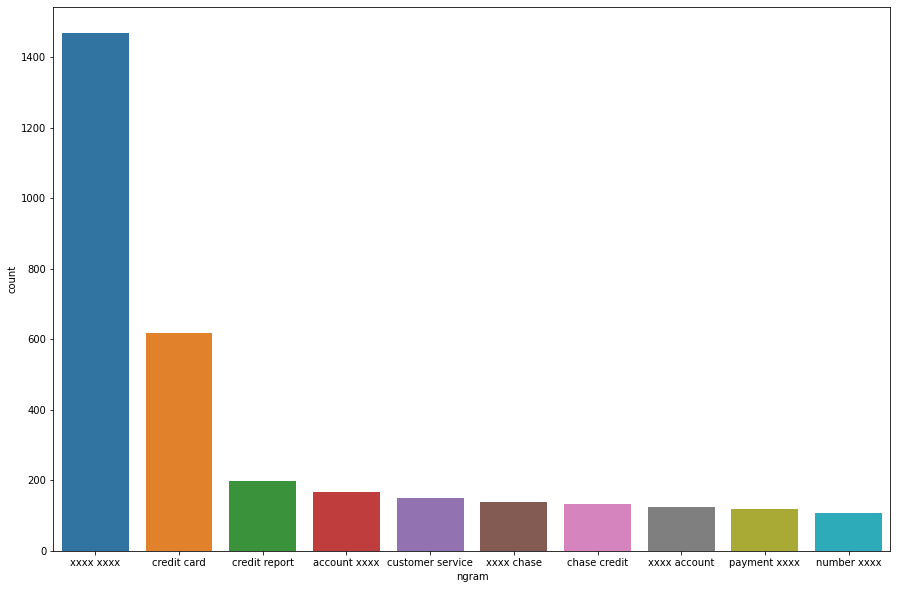

In [40]:
# Print the top 10 words in the bigram frequency
top_10_bigram = get_top_n_bigrams(df_clean['complaint_clean'], n=10)
for i in top_10_bigram:
    print(i[0])

plot_ngrams(top_10_bigram)

In [41]:
# Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_trigrams(df_clean['complaint_clean'], n=30)

[('xxxx xxxx xxxx', 327),
 ('chase credit card', 94),
 ('xxxx credit card', 46),
 ('credit card company', 44),
 ('xxxx payment xxxx', 44),
 ('credit card account', 42),
 ('payment xxxx xxxx', 38),
 ('credit card chase', 32),
 ('xxxx xxxx payment', 32),
 ('account xxxx xxxx', 30),
 ('xxxx xxxx chase', 28),
 ('credit card xxxx', 28),
 ('payment xxxx payment', 26),
 ('customer service representative', 23),
 ('xxxx xxxx credit', 23),
 ('number xxxx xxxx', 22),
 ('credit report xxxx', 21),
 ('account credit report', 20),
 ('xxxx xxxx account', 20),
 ('credit score xxxx', 20),
 ('address xxxx xxxx', 20),
 ('company xxxx xxxx', 19),
 ('credit card number', 19),
 ('chase customer service', 19),
 ('credit card credit', 18),
 ('social security number', 16),
 ('email xxxx xxxx', 16),
 ('xxxx customer service', 16),
 ('transaction xxxx xxxx', 16),
 ('xxxx credit report', 16)]

xxxx xxxx xxxx
chase credit card
xxxx credit card
credit card company
xxxx payment xxxx
credit card account
payment xxxx xxxx
credit card chase
xxxx xxxx payment
account xxxx xxxx


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'xxxx xxxx xxxx'),
  Text(1, 0, 'chase credit card'),
  Text(2, 0, 'xxxx credit card'),
  Text(3, 0, 'credit card company'),
  Text(4, 0, 'xxxx payment xxxx'),
  Text(5, 0, 'credit card account'),
  Text(6, 0, 'payment xxxx xxxx'),
  Text(7, 0, 'credit card chase'),
  Text(8, 0, 'xxxx xxxx payment'),
  Text(9, 0, 'account xxxx xxxx')])

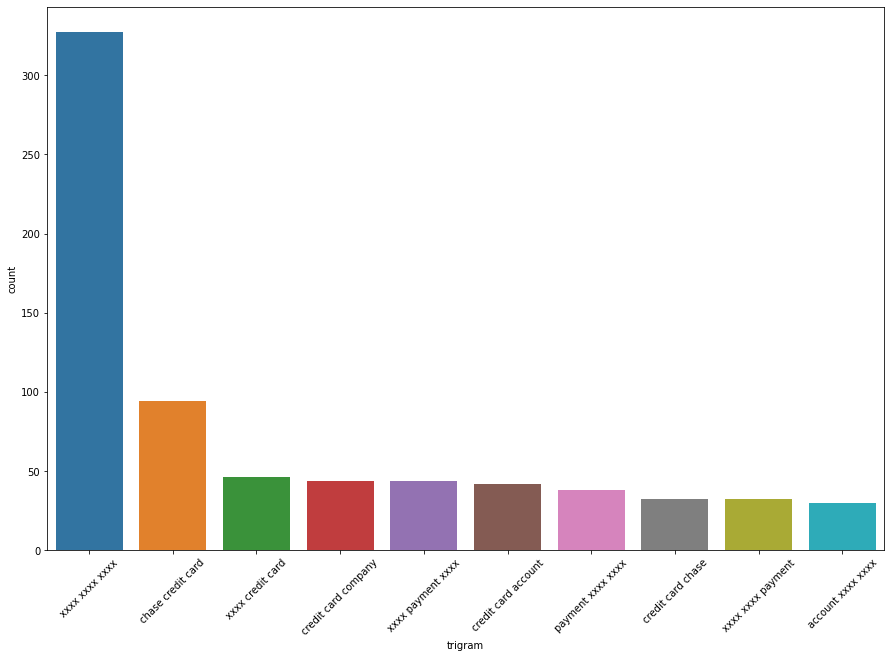

In [42]:
# Print the top 10 words in the trigram frequency
top_10_trigram = get_top_n_trigrams(df_clean['complaint_clean'], n=10)
for i in top_10_trigram:
    print(i[0])

x = pd.DataFrame(top_10_trigram,columns=['trigram','count'])
plt.figure(figsize=(15,10))
sns.barplot(x=x['trigram'],y=x['count'])
plt.xticks(rotation=45)

## Remove xxxx
The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [43]:
df_clean['complaint_clean'].head()

0    good morning name xxxx appreciate service chas...
1    xxxx card agent upgrade anniversary date agent...
2    card however fraudulent application identity c...
3    xxxx xxxx ticket offer ticket reward card info...
4    grand son check deposit account never money gr...
Name: complaint_clean, dtype: object

In [44]:
# Test the regex on a samplt string
sub_word = re.sub('xxxx[x]*', '', "abc xxxx def xxxxx ghi xxxxxxxxx jkl");print(sub_word)
sub_word.replace('  ',' ')

abc  def  ghi  jkl


'abc def ghi jkl'

In [45]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx[x]*', '', regex=True)
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('  ', ' ')

In [46]:
# Remove chase which is the top most word which is the name of the bank
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('chase', '')

In [47]:
#All masked texts has been removed
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name xxxx appreciate service chas...,good morning name appreciate service debt ver...
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",xxxx card agent upgrade anniversary date agent...,card agent upgrade anniversary date agent wro...
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...,card however fraudulent application identity c...
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information o...
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",grand son check deposit account never money gr...,grand son check deposit account never money gr...


In [48]:
df_clean['complaint_clean'].head()

0    good morning name appreciate service  debt ver...
1     card agent upgrade anniversary date agent wro...
2    card however fraudulent application identity c...
3     ticket offer ticket reward card information o...
4    grand son check deposit account never money gr...
Name: complaint_clean, dtype: object

In [49]:
comment_words = ""
for words in df_clean['complaint_clean'].tolist():
    comment_words += words

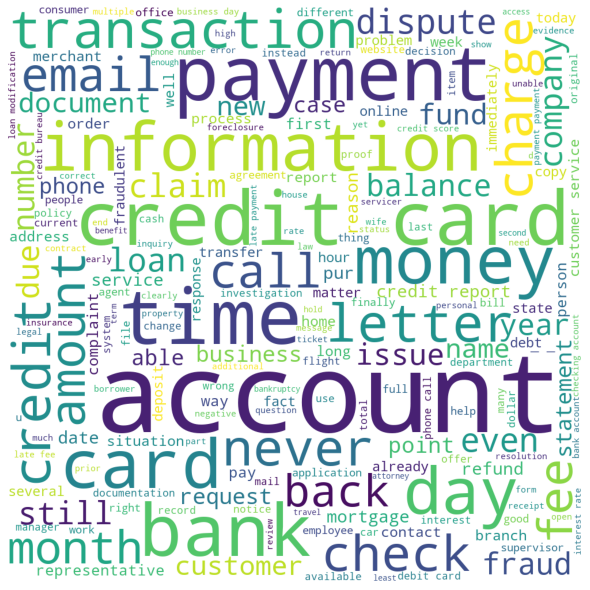

In [50]:
plotWordCloud(comment_words)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [51]:
df_clean['complaint_clean'].head()

0    good morning name appreciate service  debt ver...
1     card agent upgrade anniversary date agent wro...
2    card however fraudulent application identity c...
3     ticket offer ticket reward card information o...
4    grand son check deposit account never money gr...
Name: complaint_clean, dtype: object

In [52]:
# Write your code here to initialise the TfidfVectorizer 
#tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer()#max_df= 90 , min_df=10)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [53]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_clean'].tolist())
print(dtm)  

  (0, 1979)	0.15917784134619906
  (0, 101)	0.2438149484160259
  (0, 4327)	0.1865479251421911
  (0, 909)	0.16322547480456476
  (0, 2201)	0.11644021917282985
  (0, 2378)	0.2064561756246229
  (0, 3728)	0.16218114607866796
  (0, 2741)	0.11429621415009979
  (0, 2553)	0.1637562783206433
  (0, 2241)	0.1694142490276401
  (0, 4685)	0.2800240574259839
  (0, 422)	0.10403670609339666
  (0, 22)	0.26472642248083755
  (0, 4096)	0.1460917986900138
  (0, 4710)	0.21815910550390047
  (0, 1088)	0.5337986514175311
  (0, 3888)	0.12282623080951571
  (0, 268)	0.2864385355698328
  (0, 2786)	0.14836169636089278
  (0, 2750)	0.21495543664598724
  (0, 1877)	0.1554449170371574
  (1, 882)	0.2183010030687432
  (1, 37)	0.06252162705330538
  (1, 2960)	0.1425914193432987
  (1, 4865)	0.15807184963085769
  :	:
  (999, 2357)	0.20443913281502832
  (999, 2026)	0.2179903832061625
  (999, 637)	0.40887826563005664
  (999, 2092)	0.2909947283156391
  (999, 77)	0.13940390502062253
  (999, 3329)	0.30356470203100033
  (999, 1948)	0.

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [54]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [55]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [56]:
# Document - Topic
W = nmf_model.fit_transform(dtm)
len(tfidf.get_feature_names())

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



4886

In [57]:
type(W), W.shape, W[:10]

(numpy.ndarray,
 (1000, 5),
 array([[0.01201658, 0.00794793, 0.03467928, 0.        , 0.05819775],
        [0.01364309, 0.02192269, 0.00153597, 0.        , 0.03895862],
        [0.        , 0.08021494, 0.        , 0.        , 0.03432891],
        [0.03537899, 0.10776147, 0.01538926, 0.        , 0.03381723],
        [0.08057128, 0.        , 0.00312865, 0.        , 0.01549379],
        [0.        , 0.13114388, 0.        , 0.        , 0.        ],
        [0.11388078, 0.        , 0.03734168, 0.03515104, 0.00903002],
        [0.00940932, 0.        , 0.13928503, 0.        , 0.03377744],
        [0.01486946, 0.        , 0.01024913, 0.        , 0.2395453 ],
        [0.        , 0.218286  , 0.        , 0.        , 0.00321401]]))

In [58]:
# Topic - Words
H = nmf_model.components_

In [59]:
type(H), H.shape, H[:10]

(numpy.ndarray,
 (5, 4886),
 array([[0.00000000e+00, 3.80785251e-03, 0.00000000e+00, ...,
         1.40784290e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.91503671e-04, 0.00000000e+00, ...,
         0.00000000e+00, 8.48269900e-04, 6.54098866e-03],
        [7.72957189e-04, 0.00000000e+00, 2.20848213e-03, ...,
         7.73912698e-04, 1.64079597e-03, 2.39070669e-02],
        [0.00000000e+00, 0.00000000e+00, 1.12559928e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.39243986e-04, 0.00000000e+00, 0.00000000e+00, ...,
         5.70850300e-05, 2.31249627e-03, 4.72715160e-03]]))

In [60]:
#Print the Top15 words for each of the topics
TOP_WORDS = 15
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, TOP_WORDS)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(TOP_WORDS)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:TOP_WORDS]
    topic_words.iloc[i] = words[ix]

topic_words.to_csv("out.csv")
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,money,check,fund,bank,deposit,day,branch,open,number,business,transfer,back,balance,name
Topic 1,credit,card,report,inquiry,company,hard,account,score,application,bureau,year,limit,letter,point,reporting
Topic 2,payment,loan,late,mortgage,interest,due,time,month,modification,year,home,car,rate,credit,statement
Topic 3,fee,overdraft,balance,charge,annual,late,transaction,account,fund,card,interest,membership,pay,month,bank
Topic 4,transaction,charge,dispute,card,claim,fraud,merchant,information,service,email,fraudulent,call,letter,customer,time


In [61]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 0': 'Bank account services',
    'Topic 1': 'Credit card / Prepaid card',
    'Topic 2': 'Others',  # 'Mortgages/loans',
    'Topic 3': 'Theft/Dispute reporting',#'Others', 
    'Topic 4': 'Mortgages/loans',  #'Theft/Dispute reporting',
}

In [62]:
#Assign the best topic to each of the complaints in Topic Column

#df_clean['Topic'] = #write your code to assign topics to each rows.
df_W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)])
df_clean['Topic'] = df_W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
df_clean['Topic']

0                 Mortgages/loans
1                 Mortgages/loans
2      Credit card / Prepaid card
3      Credit card / Prepaid card
4           Bank account services
                  ...            
995               Mortgages/loans
996                        Others
997                        Others
998         Bank account services
999                        Others
Name: Topic, Length: 1000, dtype: object

In [63]:
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name xxxx appreciate service chas...,good morning name appreciate service debt ver...,Mortgages/loans
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",xxxx card agent upgrade anniversary date agent...,card agent upgrade anniversary date agent wro...,Mortgages/loans
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...,card however fraudulent application identity c...,Credit card / Prepaid card
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information o...,Credit card / Prepaid card
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",grand son check deposit account never money gr...,grand son check deposit account never money gr...,Bank account services


In [64]:
df_clean.shape

(1000, 5)

In [65]:
#Print the first 5 Complaint for each of the Topics
df_clean_gp = df_clean.groupby('Topic').head(10)
df_clean_gp[['complaint_clean','Topic']].sort_values('Topic')

def showSampleComplaintsOfTopic(topic):
    print("Topic", topic)
    [print(complaint, "\n") for complaint in df_clean_gp[df_clean_gp['Topic']==topic]['complaint_clean'].values[0:10]]

In [66]:
showSampleComplaintsOfTopic('Bank account services')

Topic Bank account services
grand son check deposit account never money grand son clear money  money grand son  time call verify check owner country time date number claim number  

account debit card branch customer service representative account actually branch fund currently well direct deposit place employment bank associate customer service representative fund additional business day branch fund actually account fund long present current statement business day date fund bank teller  business day recover fund left account currently unfortunately additional financial bind fee late rent late car payment short giving notice thing actually peace mind fact  situation grossly even bank teller inform account suspicious suspicious look right close account time protocol past notice form document notice thing actually peace mind fact  situation grossly even bank teller inform account suspicious suspicious look right close account time protocol past notice form document situation truly liveli

In [67]:
showSampleComplaintsOfTopic('Credit card / Prepaid card')

Topic Credit card / Prepaid card
card however fraudulent application identity consent fraudulently service extend credit identity applicant 

 ticket offer ticket reward card information offer minute screen decision immediately immediately bank notification screen representative spoke application information offer even credit offer first account statement pur ticket explicitly glad absolutely long interested account application representative obliged later application explicit request application contrary representative  fact ahead open credit account name credit report  correct information credit report even ahead process application consent error 

inquiry 

credit card incorrectly datum credit report company resolve issue 

 several time fraudulent inquiry need call contact original creditor inquiry report several attempt  bank contact bureau inquiry able right person care issue many attempt fraudulent inquiry credit report legal action never credit account iquiry want matter 

seni

In [68]:
showSampleComplaintsOfTopic('Mortgages/loans')

Topic Mortgages/loans
good morning name appreciate service  debt verification statement acceptable bank validate debt instead mail month debt right know information consumer  thank advance help 

 card agent upgrade anniversary date agent wrong information order upgrade account anniversary date consent agent 

 payment online retailer quick  website scam website confirmation product response inquiry order  information transaction attempt refund retailer bank  message way reverse transaction contact information recipient message response original email transfer however website scam inquiry email expertise team order well refund request call consumer online technical support team number email situation claim department call transaction  information outside transfer agent end call quickly possible interrupt closing script contact number opportunity information right question word phrase use information system initially call bank app initiate transaction navigate menu customer service agen

In [69]:
showSampleComplaintsOfTopic('Others')

Topic Others
summer month experience decline income due employment therefore month payment extension auto loan company  almost year request payment extension never delinquent auto loan payment however month payment extension year situation representative supervisor avail lengthy discussion informed reason contractual reason denial therefore office executive director communication  week later office representative role help matter representative conference call department handing request information request still policy change explanation representative letter explanation letter reason denial policy change cfpb denial payment extension request especially clear reason denial 

loan modification  runaround mo behind payment aens always 

pur payment  payment closing date attached statement statement outstanding pur balance previous month statement show pur prior however statement show still balance promotional balance  promotional balance difference apparently minimum payment  thought pur

In [70]:
showSampleComplaintsOfTopic('Theft/Dispute reporting')

Topic Theft/Dispute reporting
concern  bank wrongly overdraft fee alert low balance unsuficent fee balance always immediatly transaction  always order overdraft fee anyway call guideline overdrawft bank fault people money ok document  refund always way back refunded first place 

multiple time late  order credit debit account late fee receipt screen shot positive balance deposit next morning multiple check first time right deposit mention eastern time last time sure deposit  eastern stuff top transaction amount thing class action lawsuit exact thing 

occasion bank  multiple overdraft fee account way process charge account large item first overdraw account small item afterwards thing balance charge one bank order subsequently overdraft fee amount complain practice way large item important item house payment car payment bank u practice courtesy charge reverse order opinion well shady business practice way bank money people payday day 

due error  transaction overdraft fee stoppayment fe

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [71]:
# Create the dictionary of Topic names and Topics
Topic_names = { 'Bank account services'         : 'Bank Account services',
                'Credit card / Prepaid card'    : 'Credit card or prepaid card',
                'Theft/Dispute reporting'       : 'Theft/Dispute Reporting',
                'Mortgages/loans'               : 'Mortgage/Loan',
                'Others'                        : 'Others' }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [72]:
df_clean[['complaint_clean', 'Topic']].head(10)

,complaint_clean,Topic
0,good morning name appreciate service debt ver...,Mortgage/Loan
1,card agent upgrade anniversary date agent wro...,Mortgage/Loan
2,card however fraudulent application identity c...,Credit card or prepaid card
3,ticket offer ticket reward card information o...,Credit card or prepaid card
4,grand son check deposit account never money gr...,Bank Account services
5,inquiry,Credit card or prepaid card
6,account debit card branch customer service rep...,Bank Account services
7,summer month experience decline income due emp...,Others
8,payment online retailer quick website scam w...,Mortgage/Loan
9,credit card incorrectly datum credit report co...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [73]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services'         : 1,
                'Credit card or prepaid card'   : 2,
                'Theft/Dispute Reporting'       : 3,
                'Mortgage/Loan'                 : 4,
                'Others'                        : 5 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [74]:
df_clean[['complaint_clean', 'Topic']].head(10)

,complaint_clean,Topic
0,good morning name appreciate service debt ver...,4
1,card agent upgrade anniversary date agent wro...,4
2,card however fraudulent application identity c...,2
3,ticket offer ticket reward card information o...,2
4,grand son check deposit account never money gr...,1
5,inquiry,2
6,account debit card branch customer service rep...,1
7,summer month experience decline income due emp...,5
8,payment online retailer quick website scam w...,4
9,credit card incorrectly datum credit report co...,2


In [75]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
from sklearn.model_selection import train_test_split
X = df_clean['complaint_clean']
y = df_clean['Topic']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)
X.shape, X_train.shape, X_test.shape
#training_data=

((1000,), (700,), (300,))

In [76]:
#training_data

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [77]:
#Write your code to get the Vector count
vec = CountVectorizer(ngram_range=(1,1)).fit(X_train)
bag_of_words = vec.transform(X_train)
print(bag_of_words.shape)
sum_of_words = bag_of_words.sum(axis=0)
words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
print(words_freq[:10])

(700, 3972)
[('account', 1558), ('credit', 1043), ('card', 977), ('payment', 699), ('time', 531), ('bank', 445), ('day', 430), ('money', 417), ('charge', 385), ('information', 360)]


In [78]:
#Write your code here to transform the word vector to tf-idf
tfidf = TfidfVectorizer().fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"X_train_tfidf.shape {X_train_tfidf.shape}, X_test_tfidf.shape {X_test_tfidf.shape}\n"\
        f"tfidf.vocabulary {len(list(tfidf.vocabulary_))}, {list(tfidf.vocabulary_)[0:10]}")

terms = tfidf.get_feature_names()
print(len(terms), terms[0:10])

X_train_tfidf.shape (700, 3972), X_test_tfidf.shape (300, 3972)
tfidf.vocabulary 3972, ['report', 'card', 'bit', 'unusual', 'entire', 'system', 'last', 'charge', 'accurate', 'replacement']
3972 ['aa', 'aback', 'abate', 'aberration', 'ability', 'able', 'abovenamed', 'abroad', 'abruptly', 'absent']


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [79]:
cv_vocab = [word for word, freq in words_freq]; print(len(cv_vocab), cv_vocab[0:10])
tfidf_vocab = list(tfidf.vocabulary_); print(len(tfidf_vocab),tfidf_vocab[0:10])
diff = set(cv_vocab)-set(tfidf_vocab);len(diff);list(diff)[0:10]

3972 ['account', 'credit', 'card', 'payment', 'time', 'bank', 'day', 'money', 'charge', 'information']
3972 ['report', 'card', 'bit', 'unusual', 'entire', 'system', 'last', 'charge', 'accurate', 'replacement']


[]

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Utility functions

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(dt_classifier, category, X, y):
    print(f"{category} Accuracy : {percent(accuracy_score(y, dt_classifier.predict(X)), 1)}%")
    print(f"{category} Confusion Matrix:")
    print(confusion_matrix(y, dt_classifier.predict(X)))

### Logistic Regression

In [132]:
# TODO

### Decision Tree

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

'''dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_tfidf, y_train)'''

'dt = DecisionTreeClassifier(max_depth=3, random_state=42)\ndt.fit(X_train_tfidf, y_train)'

In [116]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 4], #  5, 10] If 5 and 10 are included, the best estimator has depth of 10 and the interpretation of the model was difficult. So using only the values of 2,3 4
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [117]:
%%time
grid_search.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 339 ms, sys: 36.2 ms, total: 375 ms
Wall time: 390 ms


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [118]:
df_score = pd.DataFrame(grid_search.cv_results_)
df_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008539,0.001215,0.001018,0.000146,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.440000,0.468571,0.491429,0.440000,0.460000,0.021571,29
1,0.012583,0.001570,0.001397,0.000128,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.451429,0.474286,0.480000,0.434286,0.460000,0.018295,29
2,0.011108,0.000700,0.001165,0.000085,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.451429,0.480000,0.491429,0.445714,0.467143,0.019113,24
3,0.011561,0.000819,0.001212,0.000205,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.491429,0.480000,0.531429,0.445714,0.487143,0.030606,23
4,0.008781,0.000798,0.001008,0.000239,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.497143,0.485714,0.497143,0.491429,0.492857,0.004738,22


In [119]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)

In [120]:
evaluate_model(dt_best, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(dt_best, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test, dt_best.predict(X_test_tfidf)))

TRAIN Accuracy : 65.57%
TRAIN Confusion Matrix:
[[ 72   4   0  71   5]
 [  4  96   0  46   1]
 [  1   1  49   7   1]
 [ 12  10   1 171   2]
 [  5   8   2  60  71]]

TEST Accuracy : 65.33%
TEST Confusion Matrix:
[[34  3  0 21  2]
 [ 1 51  0 15  1]
 [ 0  1 20  2  1]
 [ 7  5  0 61  2]
 [ 5  9  2 27 30]]

              precision    recall  f1-score   support

           1       0.72      0.57      0.64        60
           2       0.74      0.75      0.74        68
           3       0.91      0.83      0.87        24
           4       0.48      0.81      0.61        75
           5       0.83      0.41      0.55        73

    accuracy                           0.65       300
   macro avg       0.74      0.67      0.68       300
weighted avg       0.71      0.65      0.65       300



In [121]:
df_fi = pd.DataFrame({"variables": terms, "feature importance": dt_best.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
827,credit,0.333354
1338,fee,0.252133
2015,loan,0.248530
32,account,0.165982
2652,principal,0.000000


In [122]:
df_clean['Topic'] = df_clean['Topic'].apply(lambda x: str(x))
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              1000 non-null   object
 1   complaint_lemma        1000 non-null   object
 2   complaint_POS_removed  1000 non-null   object
 3   complaint_clean        1000 non-null   object
 4   Topic                  1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [123]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

''' 'Bank Account services'   : 1, 'Credit card or prepaid card' : 2,
    'Theft/Dispute Reporting': 3, 'Mortgage/Loan'               : 4,    'Others' : 5 '''
from graphviz import Source
def get_dt_graph(dt_classifier, features):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True, feature_names=features, class_names=["1", "2", "3", "4", "5"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"15,25!"')
    return graph.create_png()

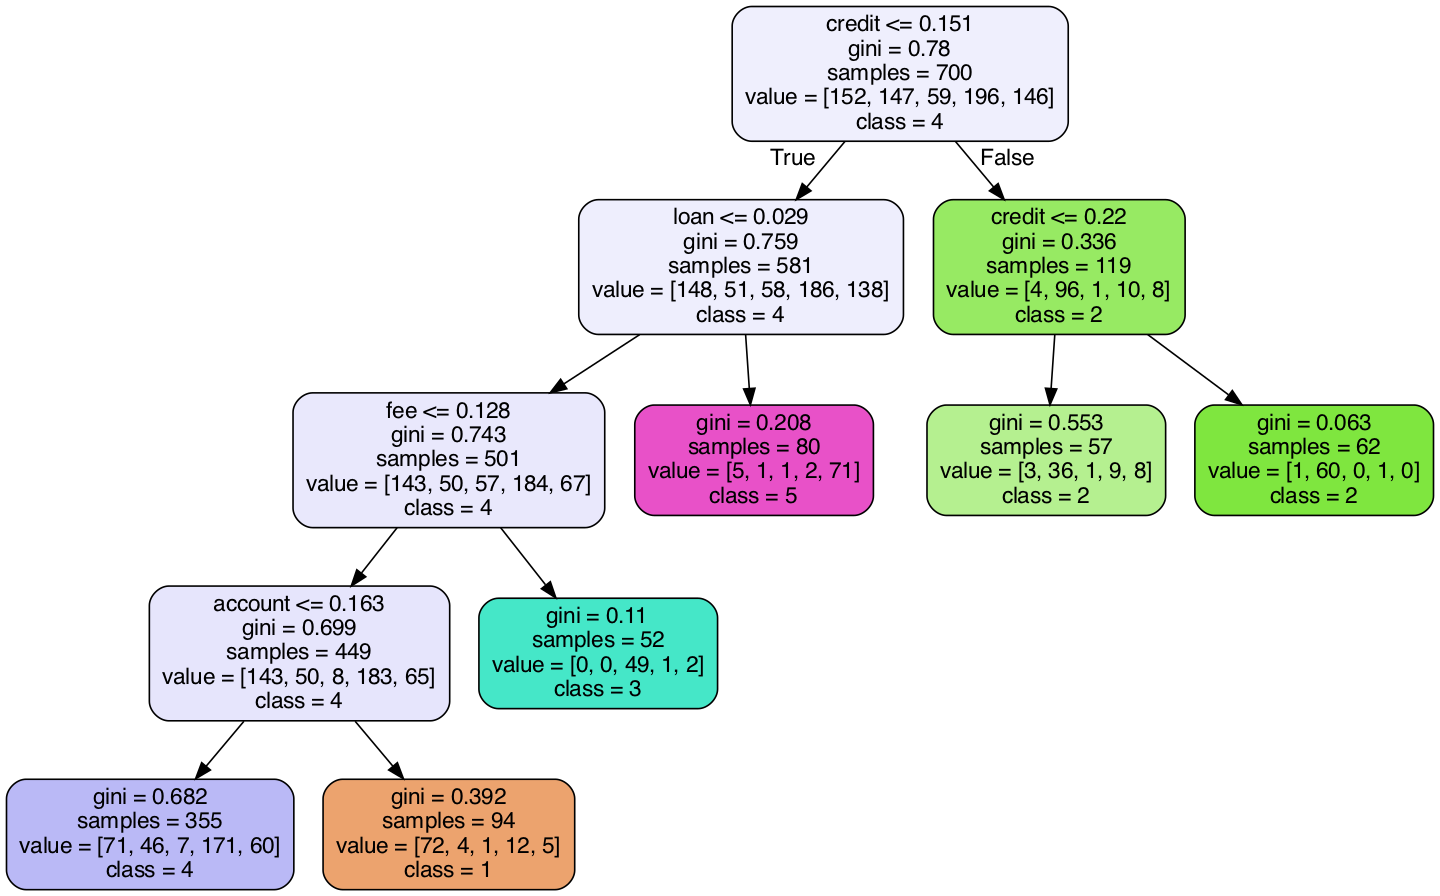

In [124]:
Image(get_dt_graph(dt_best, terms))

### Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3,oob_score=True)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [4, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [4, 8, 12],
    'n_estimators': [10, 30, 50, 100, 200]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, oob_score=True), param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [126]:
%%time
grid_search.fit(X_train_tfidf,y_train)

Fitting 4 folds for each of 225 candidates, totalling 900 fits


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any

CPU times: user 3.07 s, sys: 196 ms, total: 3.27 s
Wall time: 20 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 10], 'max_features': [4, 8, 12],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [127]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=5,
                       n_estimators=30, oob_score=True, random_state=42)

In [128]:
evaluate_model(rf_best, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(rf_best, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test, rf_best.predict(X_test_tfidf)))

TRAIN Accuracy : 51.71%
TRAIN Confusion Matrix:
[[ 34   1   0 114   3]
 [  0  81   0  66   0]
 [  1   1   0  52   5]
 [  1   0   0 194   1]
 [  1   5   0  87  53]]

TEST Accuracy : 45.33%
TEST Confusion Matrix:
[[11  0  0 49  0]
 [ 1 31  0 35  1]
 [ 1  0  0 20  3]
 [ 0  0  0 74  1]
 [ 0  5  0 48 20]]

              precision    recall  f1-score   support

           1       0.85      0.18      0.30        60
           2       0.86      0.46      0.60        68
           3       0.00      0.00      0.00        24
           4       0.33      0.99      0.49        75
           5       0.80      0.27      0.41        73

    accuracy                           0.45       300
   macro avg       0.57      0.38      0.36       300
weighted avg       0.64      0.45      0.42       300



/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



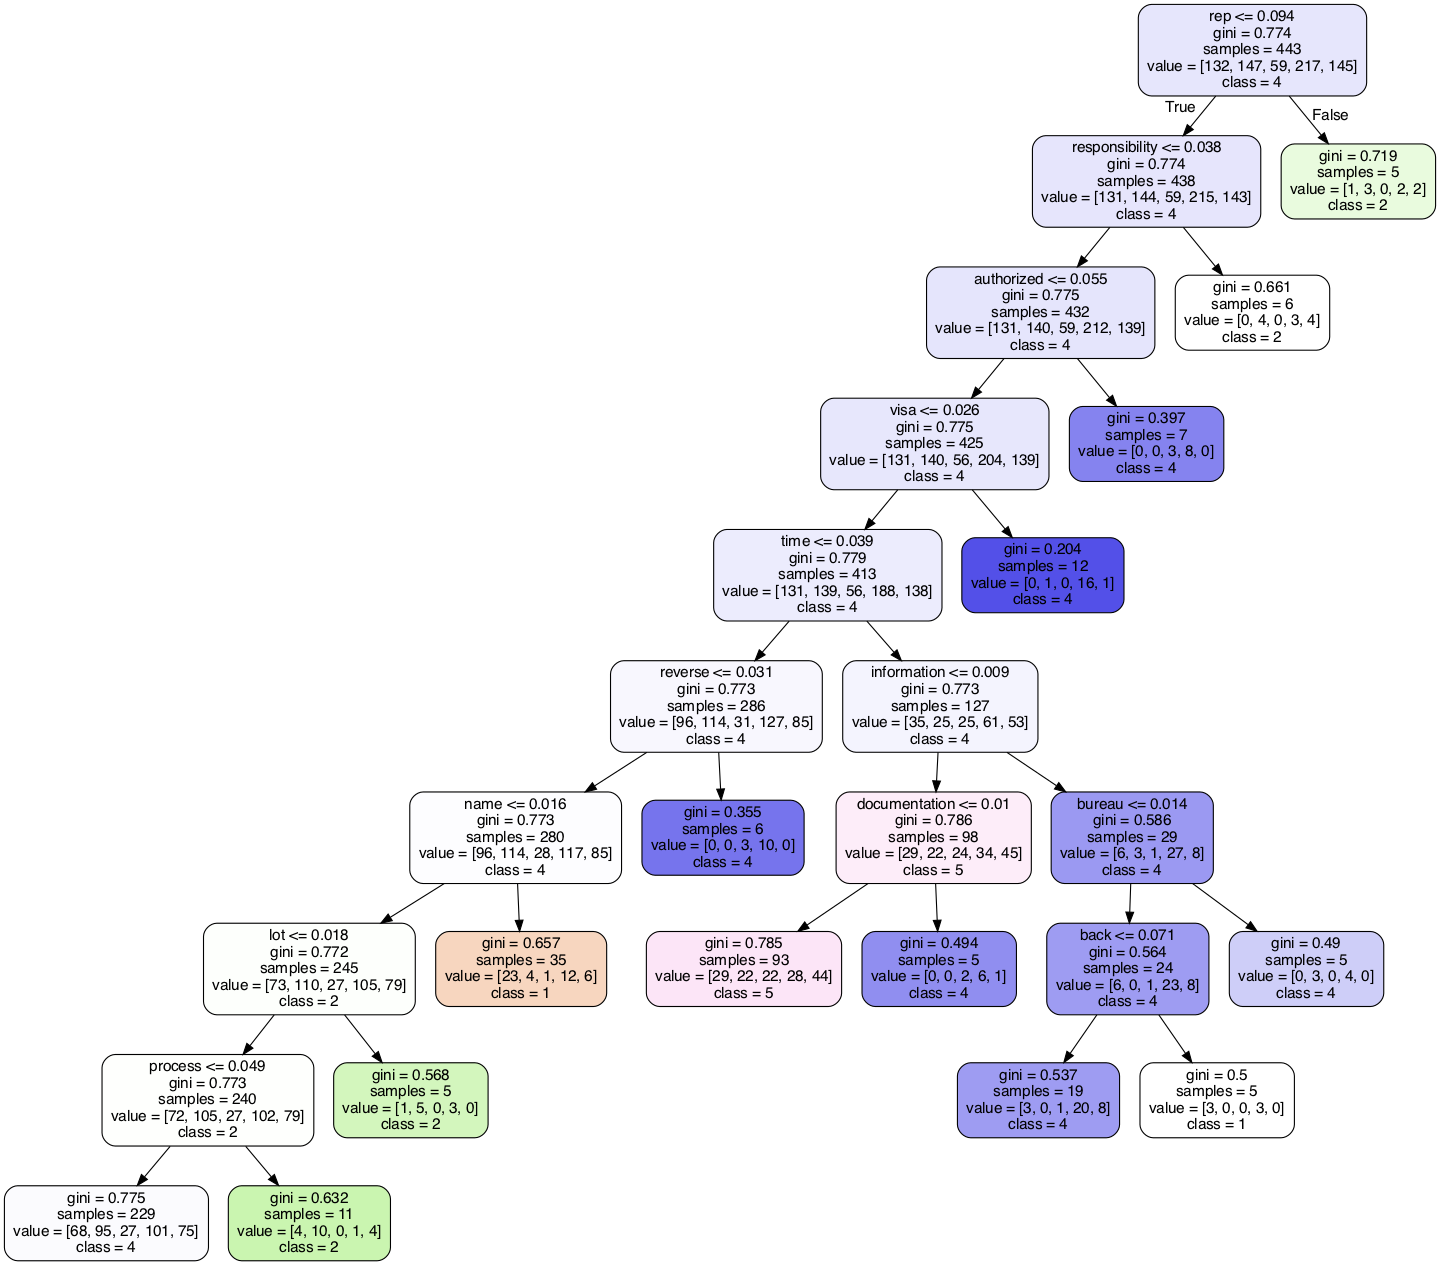

In [129]:
Image(get_dt_graph(rf_best.estimators_[0],terms), height=600, width=600)

In [130]:
rf_best.oob_score_*100

41.285714285714285

### Summary

| Classifier | TRAIN Accuracy | TEST Accuracy |
|---|---|---|
| LogisticRegression | | |
| DecisionTreeClassifier(max_depth=4, min_samples_leaf=50) | 65.57% | 65.33% |
| RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=5,n_estimators=30, oob_score=True, random_state=42) |  51.71% | 45.33% |

In [131]:
# Write your code here to build any 3 models and evaluate them using the required metrics

